In [138]:
import prosail
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.optimize
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['figure.figsize'] = (14, 14)

### Biophysical parameter estimation -  Maximum Likelihood optimization problem. 

##### Alfonso Diz-Lois dizlois@gmail.com

The goal here is to implement a maximum likelihood estimator (MLE) for the parameters of a non-linear observational operator $H(x)$ given some observations $y$ whose error is assumed to be normally distributed  $N\left(0,\sigma\right)$ :

$$P(y\mid x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{ - \frac{\left( {H(x) - y_{obs} } \right)^2 }{2\sigma ^2 }}$$  <div style="text-align: right">(1)</div>

In this example, the observational operator will be the transformation of several inputs(LAI,CAB,etc..) into a Sentinel2 observation by using the [PROSAIL model](https://github.com/jgomezdans/prosail) and [the Spectral Response Functions of the bands of interest](https://github.com/jgomezdans/MULTIPLY_MCMC_explore/blob/master/S2A_SRS.csv). 

$y$ represents a Sentinel2 sample and LAI (Leave Area Index) will be the unknown parameter $x$

Maximizing $P\left( y\mid x \right))$ is equivalent to minimizing its -log function:



$$
J(x)=\sum \frac{\left ( H(x)-y_{obs} \right )^{2}}{2\sigma^{2}}
$$
<div style="text-align: right">(2)</div>

The numerator represents the residuals squared, while the denominator weights them in terms of the variance of the observation which is quite intuitive.

Scipy.optimize is finally used in order to find the minimum of our function and therefore, the "most likely" value of LAI.

### Creating synthetic observations $y$....

First of all, we need some observations for our estimates to be compared with. 

To this end, a synthetic spectrum is generated using PROSAIL. Parameters are fixed (LAI=3).

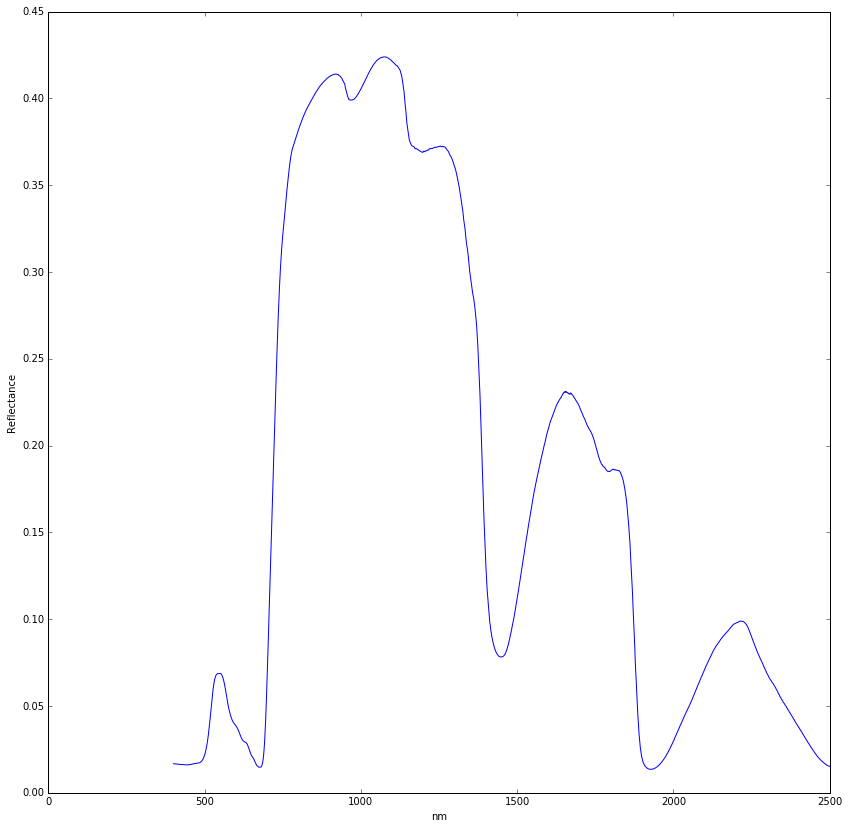

In [139]:
# define the model parameters here
n = 1.8
cab = 37.
car = 8.
cbrown = 0.3
cw = 0.013
cm = 0.005
lai = 3.
lidfa = 45.


# assuming black soil
rho_syn = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))

# plot to check it looks sensible
wv = np.arange(400, 2501)
_ = plt.plot(wv, rho_syn)
plt.xlabel("nm")
plt.ylabel("Reflectance")


Next step is to scale each band range using Sentinel2A SRS.
Given the nature of the PROSAIL model (mostly vegetation-related), only some bands are included.
We can see some examples of the effect of the transformation.


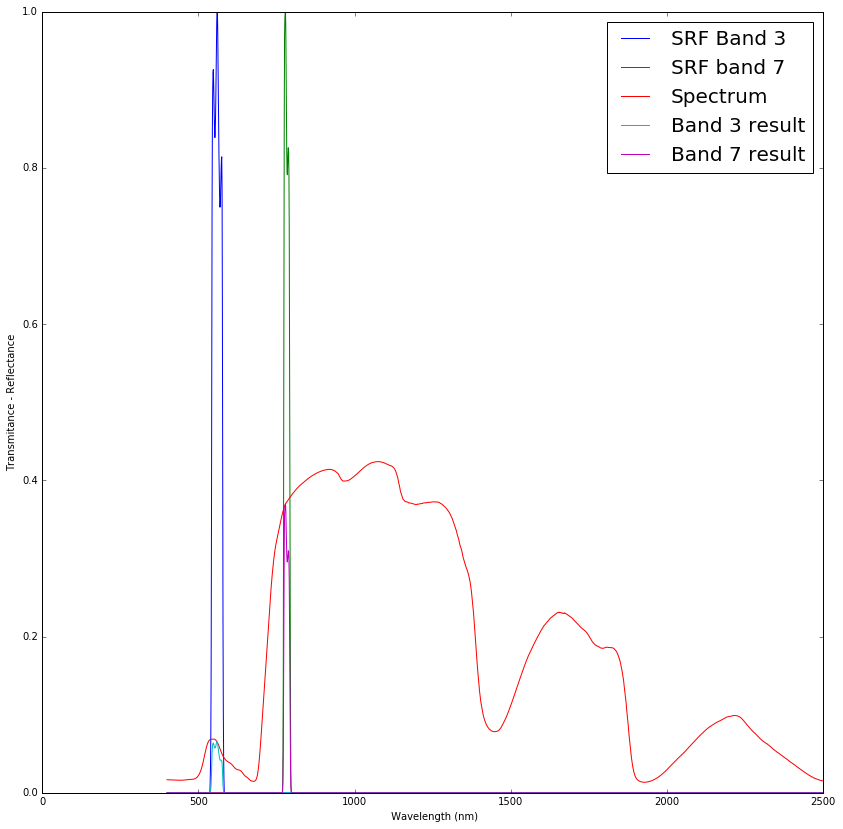

In [140]:
srf = np.loadtxt("./MULTIPLY_MCMC_explore/S2A_SRS.csv", skiprows=1, delimiter=",")[100:, :]
#Bands of interest
srf_land = srf[:, [1, 2, 3, 4, 5, 6, 7, 8, 11, 12]]
wv_land = np.array([486.0, 560.5, 665.0, 704.5, 740.0, 783.0,
                    838.84, 863.25, 1610.5, 2199.0])
# Apply the SRF to the data simulated above
rho_s2a = (rho_syn[:, None]*srf_land)


#Example, band 3
plt.plot(srf[:,0],srf[:,3],label="SRF Band 3")
plt.plot(srf[:,0],srf[:,7],label="SRF band 7")
plt.plot(srf[:,0],rho_syn,label="Spectrum")
plt.plot(srf[:,0],rho_s2a[:,2],label="Band 3 result")
plt.plot(srf[:,0],rho_s2a[:,6],label="Band 7 result")
plt.legend(loc='upper right',prop={'size': 20})
plt.xlabel(" Wavelength (nm)")
plt.ylabel("Transmitance - Reflectance")
plt.show()

In order to make our sample more "real", some gaussian noise (10%) is added. 

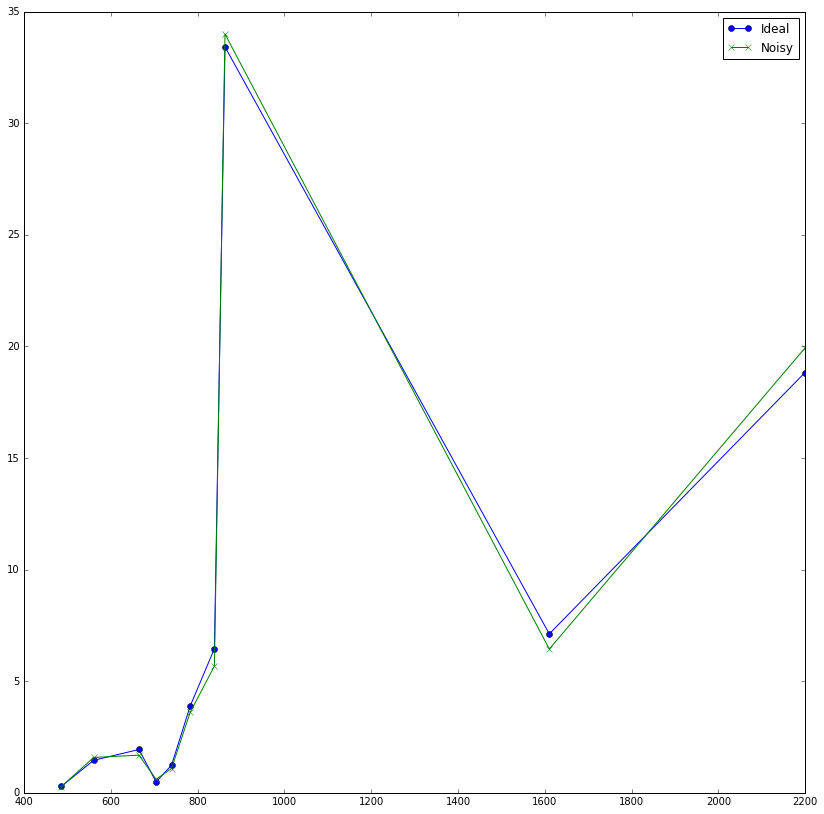

In [141]:
#Integration...
rho_s2a = rho_s2a.sum(axis=0)

# Add some grotty noise 10 % Normal distribution
rho_s2a_noise = rho_s2a + rho_s2a*0.1*np.random.randn(10)

# Plot stuff
plt.plot( wv_land, rho_s2a, 'o-', label="Ideal")
plt.plot( wv_land, rho_s2a_noise, '-x', label="Noisy")
plt.legend(loc="best")

## Infering the parameters...

The last step is to infer the unknown parameter $x$ (LAI) from our observation by minimizing the cost function $J(x)$. Note that there is no analytic solution to the derivative of the PROSAIL model with respect to the parameters, so the optimization must be performed graphically (Nelder-Mead algorithm performed well in this simple example).


Optimization terminated successfully.
         Current function value: 5.154083
         Iterations: 41
         Function evaluations: 82
[ 2.55576632]


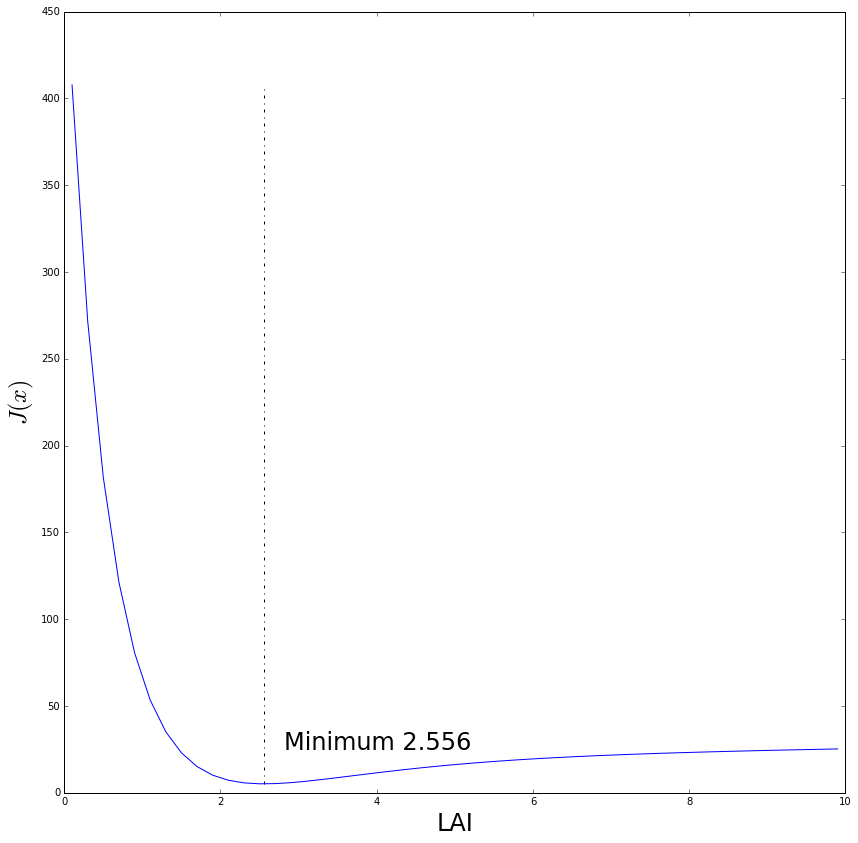

In [142]:
#COST FUNCTION

def cost(lai_input):
    
    '''
    Return J at x
    '''
    # define the model parameters here for reasonably easy update
    lai_input=lai_input[0]
    # run the model forward. rsoil0 is the soil albedo array
    # assuming black soil
    rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai_input, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    
    # Apply SRFs
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    # Residual predicted - measrued
    
    xx = rho_pred - rho_s2a_noise
    # Figure out noise. 
    sigma_obs = 0.1*rho_s2a_noise
    return (0.5*xx**2/sigma_obs**2).sum()

# starting guess
x0=0.
#Optimization
res = scipy.optimize.minimize(cost, x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
#Solution
print(res.x)

#Cost function plot...
x=np.arange(0.1,10,0.2)
cost_=[]
for i in x:
    cost_.append(cost([i]))
plt.plot(x,cost_)
plt.xlabel("LAI",fontsize=24)
plt.ylabel("$J(x)$",fontsize=24)
plt.vlines(res.x,min(cost_),max(cost_),linestyles= 'dashdot')
plt.text(res.x*1.1,min(cost_)+20,"Minimum "+str(round(res.x[0],3)),fontsize=24)

plt.show()

Now let's take a look at the shape of the probability distribution of our unknown parameter ($exp(-J(x))$)

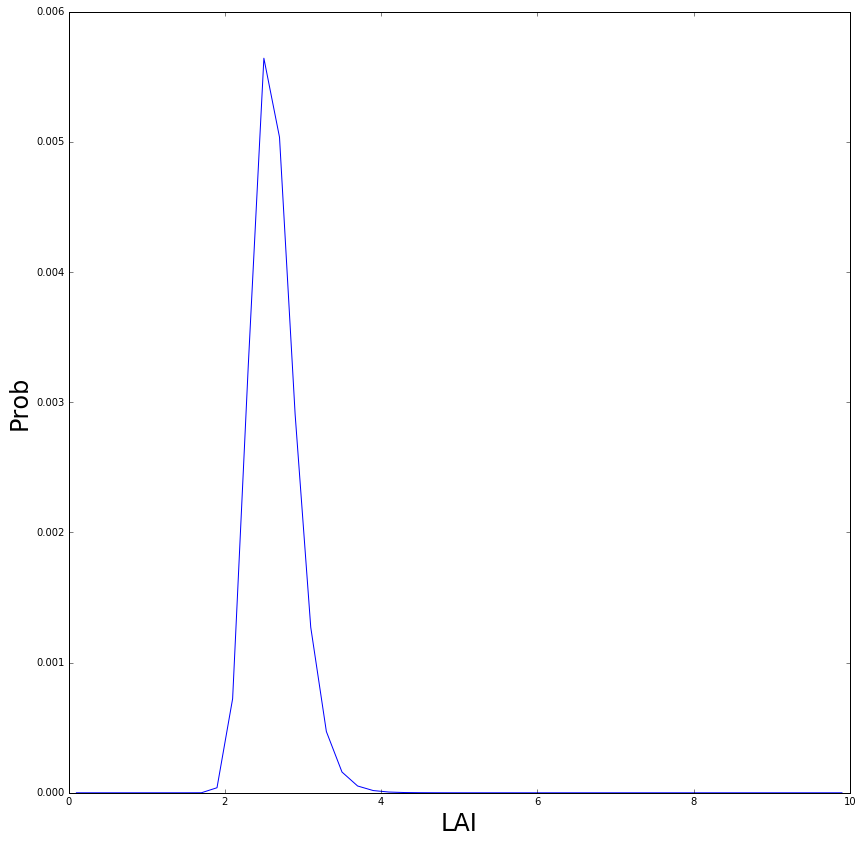

In [143]:
sigma_obs= 0.1*rho_s2a_noise
plt.plot(x,np.exp(-np.asarray(cost_)))
plt.ylabel("Prob",fontsize=24)
plt.xlabel("LAI",fontsize=24)
plt.show()

* Note that the pdf in the previous graph is not normalized and therefore do not integrate to 1.

More than one parameter can be infered using this approach, but depending on the shape of the observational operator, a single minimum may not be easily determined. 

Let's try with LAI and leaf chlorophyll content (CAB) this time.

In [144]:
def cost(z):
    
    '''
    Return J at x
    '''
    n = 1.8
    cab = z[0]
    car = 8.
    cbrown = 0.3
    cw = 0.013
    cm = 0.005
    lai = z[1]
    lidfa = 45.
    # run the model forward. rsoil0 is the soil albedo array
    # assuming black soil
    rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    
    # Apply SRFs
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    # Residual predicted - measrued
    
    xx = rho_pred - rho_s2a_noise
    # Figure out noise. 
    sigma_obs = 0.1*rho_s2a_noise
    return (0.5*xx**2/sigma_obs**2).sum()


x0=[0,0]
#Optimization
res = scipy.optimize.minimize(cost, x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
#Solution
print(res.x)

Optimization terminated successfully.
         Current function value: 4.930263
         Iterations: 128
         Function evaluations: 257
[ 39.2923759    2.63051225]


A minimum was found. Again let's check what the shape of our cost function looks like.

In [145]:

#Samples
s=100
a=np.arange(0,60,60./s)
b=np.arange(0,10,10./s)
X,Y=np.meshgrid(a,b)
Z=np.zeros((s,s))
for i in range(s):
    for j in range(s):
        Z[i,j]=cost([X[i,j],Y[i,j]])

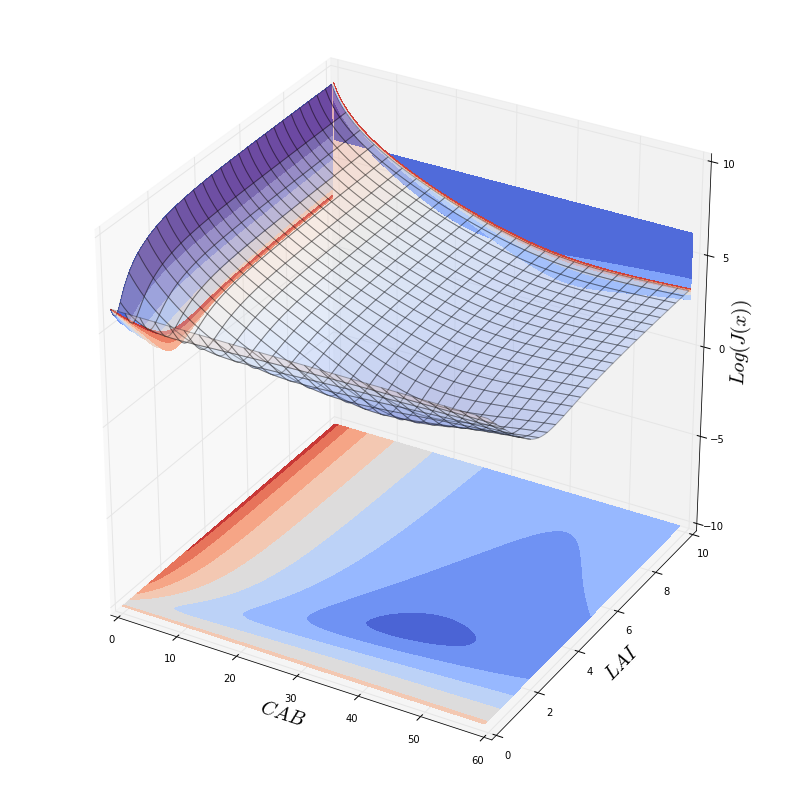

In [146]:
from matplotlib import cm
#Let's apply log to get a clearer plot scale....
W=np.log(Z)
fig = plt.figure()
ax = fig.gca(projection='3d')
#X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, W, rstride=4, cstride=4, alpha=0.3 , cmap=cm.coolwarm)
cset = ax.contourf(X, Y, W, zdir='z',offset=-10, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, W, zdir='x', offset=0, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, W, zdir='y', offset=10, cmap=cm.coolwarm)

ax.set_xlabel('$CAB$',fontsize=20)
ax.set_xlim(0, 60)
ax.set_ylabel('$LAI$',fontsize=20)
ax.set_ylim(0, 10)
ax.set_zlabel('$Log(J(x))$',fontsize=20)
ax.set_zlim(-10, 10)
plt.show()

Cost function is plotted on a log-scale for clearer visualizarion.
Now ($exp(-J(x))$)

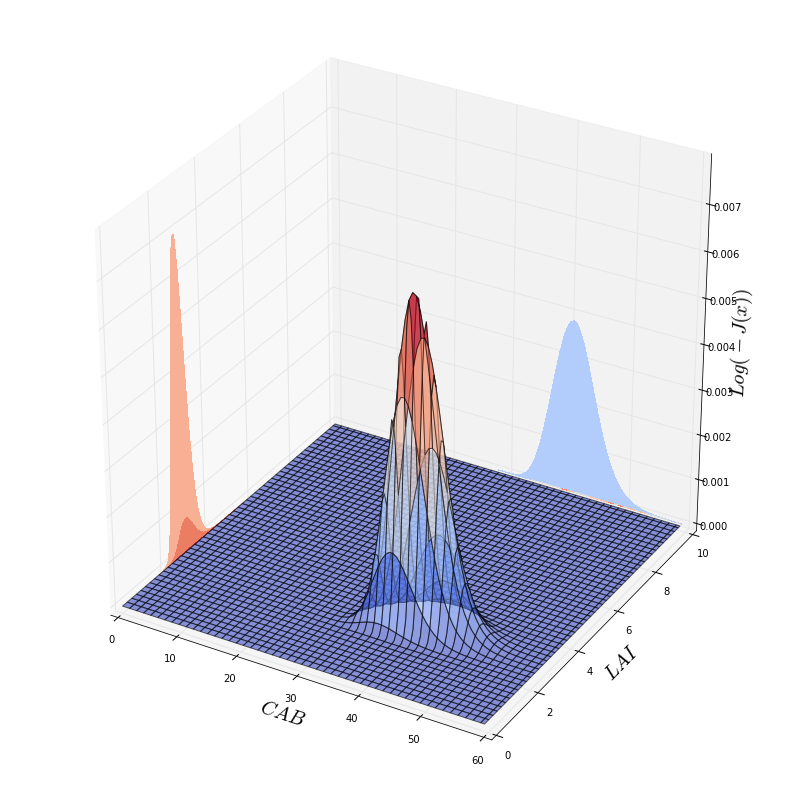

In [147]:
D=np.exp(-Z)
D[np.isnan(D)]=0.
fig = plt.figure()
ax = fig.gca(projection='3d')
#X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, D, rstride=2, cstride=2, alpha=0.6,cmap=cm.coolwarm)
cset = ax.contourf(X, Y, D, zdir='z',offset=-10, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, D, zdir='x', offset=0, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, D, zdir='y', offset=10, cmap=cm.coolwarm)

ax.set_xlabel('$CAB$',fontsize=20)
ax.set_xlim(0, 60)
ax.set_ylabel('$LAI$',fontsize=20)
ax.set_ylim(0, 10)
ax.set_zlabel('$Log(-J(x))$',fontsize=20)
ax.set_zlim(0, 1.1*np.max(D))
plt.show()

### Uncertainty 


When the model $H(x)$ is linear, the probability of the infered vector is normally distributed, and the cost function is quadratic, as captured by its Hessian matrix.
For a nonlinear model the cost function is not globally quadratic. However, for sufficiently smooth functions there exists a range around any x where J is approximately quadratic and its curvature is described
locally by the Hessian. In the vicinity of its minimum x̂ the cost function can be approximated, to second order, by the quadratic form (Kalmikov, Alexander G., and Patrick Heimbach. “A Hessian Based Method for Uncertainty Quantification in Global Ocean State Estimation.” SIAM Journal on Scientific Computing 36, no.
5 (January 2014): S267–S295.).


In [160]:
#FUNCTION TAKEN FROM https://gist.github.com/jgomezdans/3144636

from scipy.optimize import approx_fprime
def hessian ( x0,cost_function, epsilon=1.e-5, linear_approx=False,lik=False):
    """
    A numerical approximation to the Hessian matrix of cost function at
    location x0 (hopefully, the minimum)
    """
    x0=np.asarray(x0)

    # ``calculate_cost_function`` is the cost function implementation
    # The next line calculates an approximation to the first
    # derivative
    if lik:
        f1 = approx_fprime( x0, cost_function,epsilon,"lik=True") 
    else:
        f1 = approx_fprime( x0, cost_function,epsilon)
    # This is a linear approximation. Obviously much more efficient
    # if cost function is linear
    if linear_approx:
        f1 = np.matrix(f1)
        return f1.transpose() * f1    
    # Allocate space for the hessian
    n = x0.shape[0]
    hessian = np.zeros ( ( n, n ) )
    # The next loop fill in the matrix
    xx = x0
    for j in xrange( n ):
        xx0 = xx[j] # Store old value
        xx[j] = xx0 + epsilon # Perturb with finite difference
        # Recalculate the partial derivatives for this new point
        if lik:
            f2 = approx_fprime( x0, cost_function,epsilon,"lik=True") 
        else:
            f2 = approx_fprime( x0, cost_function,epsilon) 
        hessian[:, j] = (f2 - f1)/epsilon # scale...
        xx[j] = xx0 # Restore initial value of x0        
    return hessian
#mean_=res.x
#hes=hessian(res.x,cost)
#hes


In [149]:
hes_I=np.matrix(hes).I
hes_I

matrix([[ 12.69451698,   0.38368754],
        [  0.38368754,   0.08679283]])

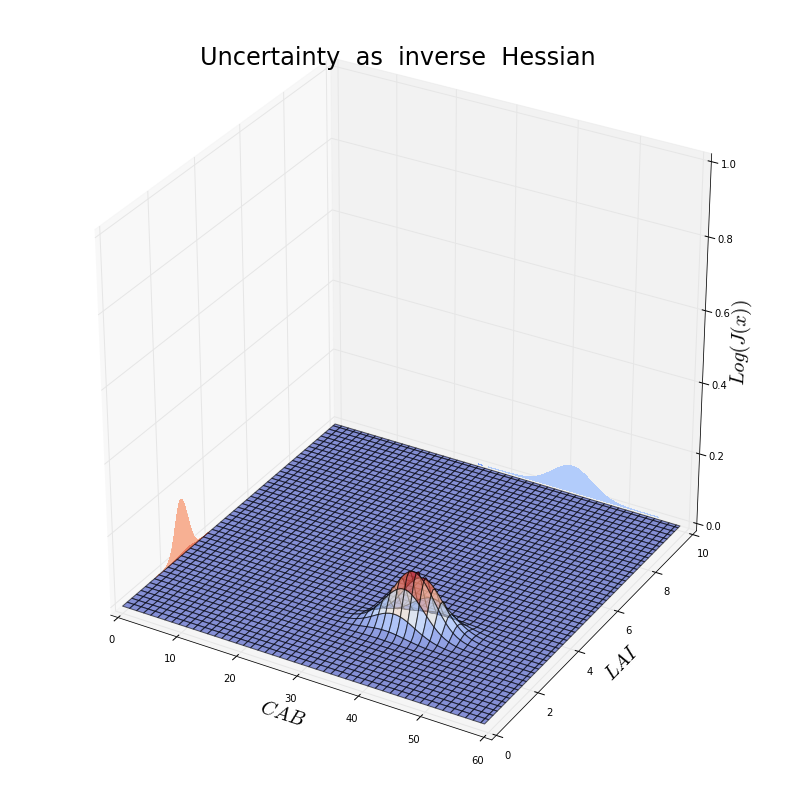

In [150]:
from scipy.stats import multivariate_normal
rv = multivariate_normal(res.x, hes_I)
s=100
a=np.arange(0,60,60./s)
b=np.arange(0,10,10./s)
X,Y=np.meshgrid(a,b)
Z=np.zeros((s,s))
for i in range(s):
    for j in range(s):
        Z[i,j]=rv.pdf([X[i,j],Y[i,j]])
        
#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=2, cstride=2, alpha=0.6,cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='z',offset=-10, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=10, cmap=cm.coolwarm)
ax.set_xlabel('$CAB$',fontsize=20)
ax.set_xlim(0, 60)
ax.set_ylabel('$LAI$',fontsize=20)
ax.set_ylim(0, 10)
ax.set_zlabel('$Log(J(x))$',fontsize=20)
ax.set_zlim(0, 1)
ax.set_title("Uncertainty  as  inverse  Hessian",fontsize=24)
plt.show()

Key points:

* Depending on the complexity of the observational model, iterations can take a while to run. Large models may require the use of emulators.
* Sometimes finding the minimum of our cost function may not be possible. Ill-posed problems can, for example, reach the minimum value at more than one value, which can also constrain the inference of several variables with an acceptable certainty.
* In such cases, extra information in the form of a  <i> a priori </i> distribution can help us to find the optimal solution. Other optimization method may be considered such as MonteCarloMarkovChains (MCMC).    

### Testing band dependence....

Pigment absorption is the dominant process in visible whereas scattering is the dominant process in near-infrared. So, what if we include all available Sentinel 2A bands?
Let's plot $Log(J(x))$ for each case... 

In [126]:
srf_land = srf[:, 1:]
rho_s2a = (rho_syn[:, None]*srf_land).sum(axis=0)
rho_s2a_noise = rho_s2a + rho_s2a*0.1*np.random.randn(13)


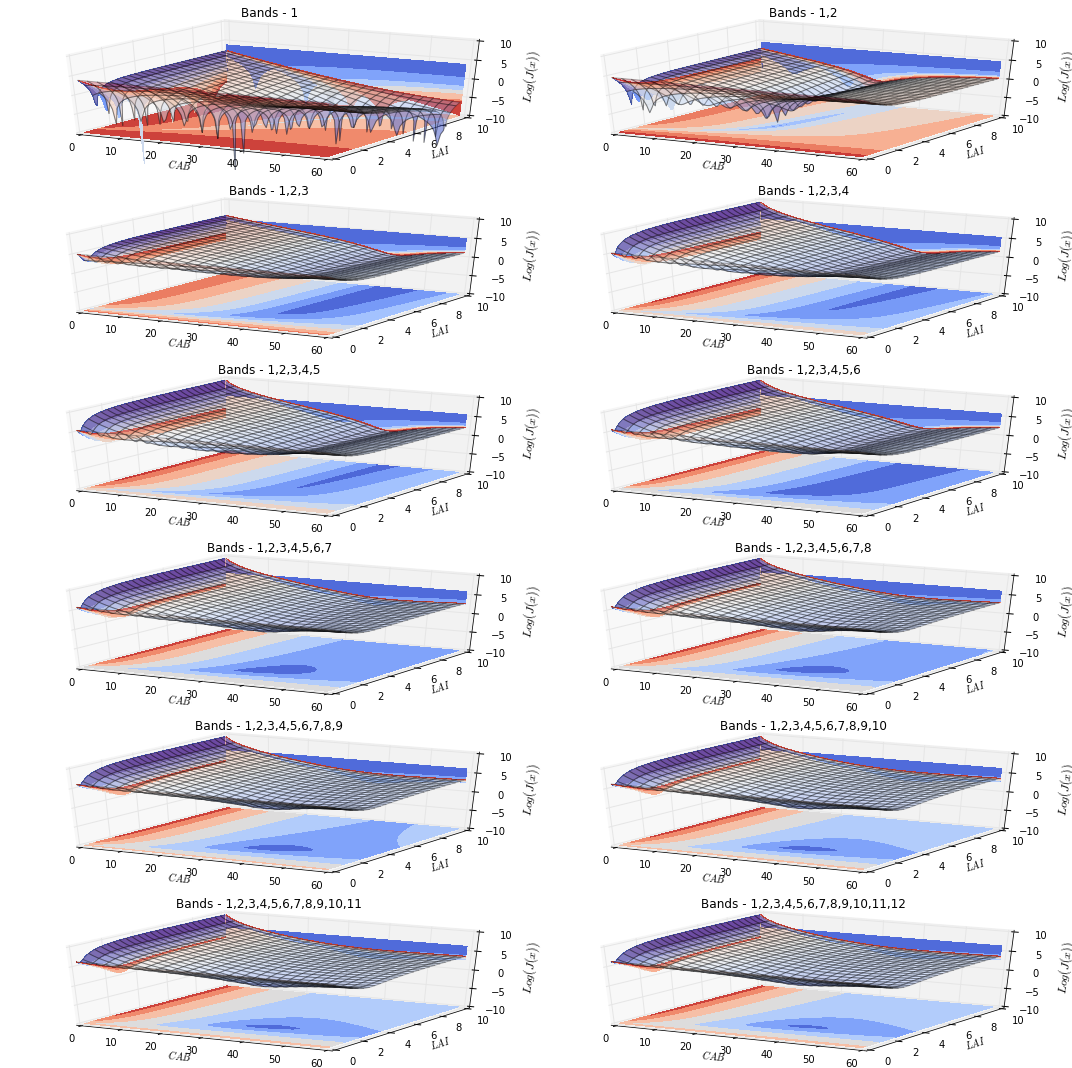

In [127]:
from matplotlib import cm
def cost_(z,bands):
    #Synthetic spectrum...
    spectrum=rho_s2a_noise[:bands]
    
    srf_land = srf[:, 1:bands+1]
    '''
    Return J at x
    '''
    n = 1.8
    cab = z[0]
    car = 8.
    cbrown = 0.3
    cw = 0.013
    cm = 0.005
    lai = z[1]
    lidfa = 45.
    # run the model forward. rsoil0 is the soil albedo array
    # assuming black soil
    rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    # Apply SRFs
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    # Residual predicted - measrued
    xx = rho_pred - spectrum
    # Figure out noise. 
    sigma_obs = 0.1*spectrum
    return (0.5*xx**2/sigma_obs**2).sum()
def get_samples(bands,logscale=False):
    s=100
    a=np.arange(0,60,60./s)
    b=np.arange(0,10,10./s)
    X,Y=np.meshgrid(a,b)
    Z=np.zeros((s,s))
    for i in range(s):
        for j in range(s):
            Z[i,j]=cost_([X[i,j],Y[i,j]],bands)
    if logscale:
        Z=np.log(Z)
    return X,Y,Z
fig=plt.figure()
fig.set_figwidth(15)
fig.set_figheight(15)
for i in np.arange(1,13,1):
    X,Y,Z=get_samples(i,logscale=True)
    ax=fig.add_subplot(6,2,i,projection="3d") 
    ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.3,cmap=cm.coolwarm)
    cset = ax.contourf(X, Y, Z, zdir='z',offset=-10, cmap=cm.coolwarm)
    cset = ax.contourf(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
    cset = ax.contourf(X, Y, Z, zdir='y', offset=10, cmap=cm.coolwarm)
    ax.set_title("Bands - "+",".join(map(lambda x:str(x),np.arange(1,i+1))))
    ax.set_xlabel('$CAB$',fontsize=10)
    ax.set_xlim(0, 60)
    ax.set_ylabel('$LAI$',fontsize=10)
    ax.set_ylim(0, 10)
    ax.set_zlabel('$Log(J(x))$',fontsize=12)
    ax.set_zlim(-10, 10)
plt.subplots_adjust(hspace=0.4)
fig.tight_layout()
plt.show()

    






It seems clear that the more bands are included, the clearer the minimum. Moreover, the area of weak probability is smaller. In fact, in those cases with less than 7 bands, we may not even be able to find a minimum.
We therefore expect the Exp(-J(x)) plot to show this more clearly.

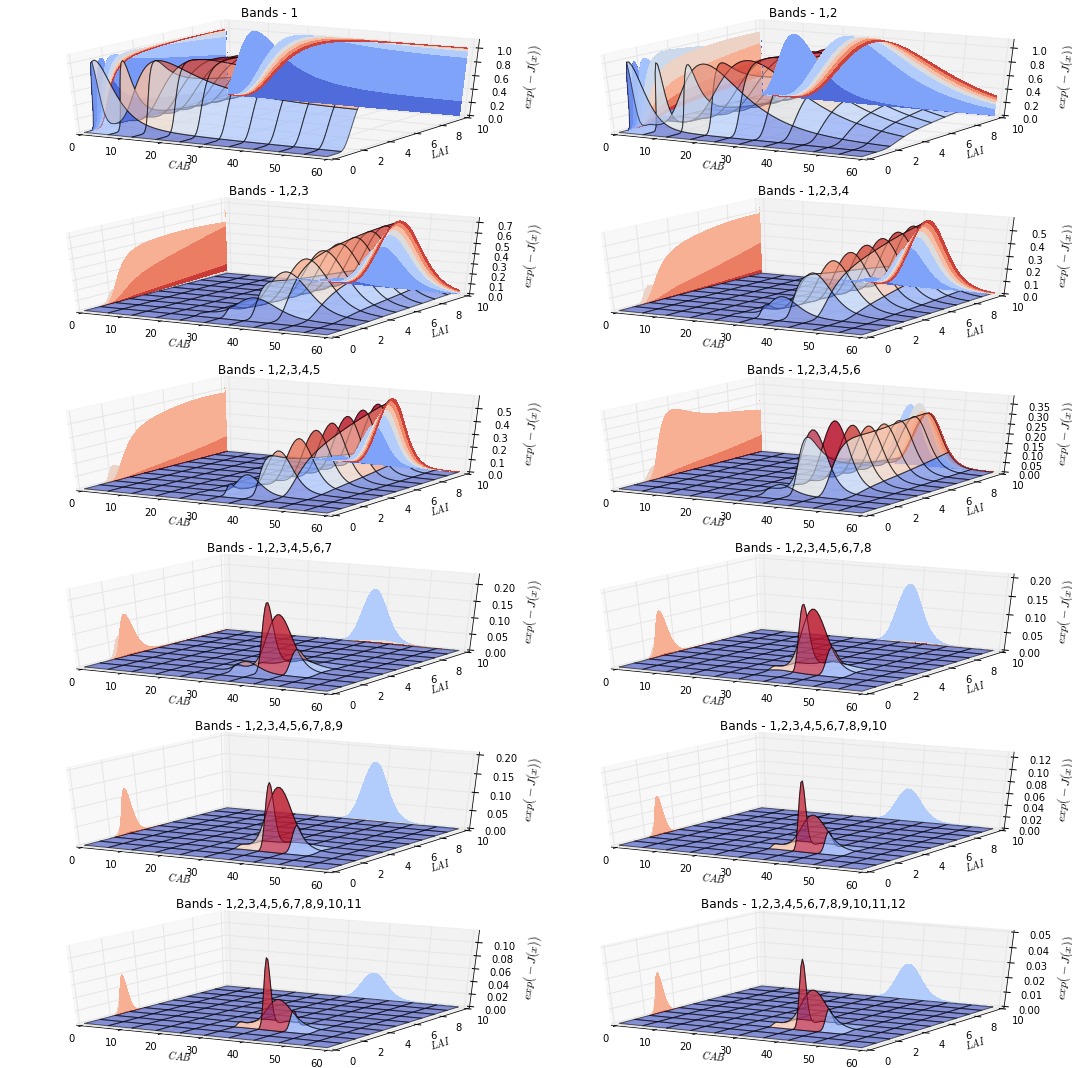

In [128]:
fig=plt.figure()
fig.set_figwidth(15)
fig.set_figheight(15)
for i in np.arange(1,13,1):
    X,Y,Z=get_samples(i)
    Z=np.exp(-Z)
    ax=fig.add_subplot(6,2,i,projection="3d") 
    ax.plot_surface(X, Y, Z, rstride=10, cstride=10, alpha=0.6,cmap=cm.coolwarm)
    cset = ax.contourf(X, Y, Z, zdir='z',offset=-10, cmap=cm.coolwarm)
    cset = ax.contourf(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
    cset = ax.contourf(X, Y, Z, zdir='y', offset=10, cmap=cm.coolwarm)
    ax.set_title("Bands - "+",".join(map(lambda x:str(x),np.arange(1,i+1))))
    ax.set_xlabel('$CAB$',fontsize=10)
    ax.set_xlim(0, 60)
    ax.set_ylabel('$LAI$',fontsize=10)
    ax.set_ylim(0, 10)
    ax.set_zlabel('$exp(-J(x))$',fontsize=12)
    ax.set_zlim(0, 1.1*np.max(Z))
plt.subplots_adjust(hspace=0.4)
fig.tight_layout()
plt.show()

## Adding more sources of information.... 

The most powerful characteristic of the bayesian approach is the possibility of adding different sources of information. 
From this standpoint, the unknown distribution is the posterior of the parameters $P\left( x\mid y\right)$ given the observations $y$



$$P\left( x\mid y\right)=\frac{P(y\mid x) P(x)}{P(y)} $$


The posterior distribution is a probability distributions that represents the update of our previous belief (prior) of the parameter after having seen the data (likelihood). 

Assuming the term $P(y)$ as a normalizing factor, we can state that the posterior is proportional to the maximum likelihood distributions times the prior....

$$P\left( x\mid y\right)\propto P(y\mid x) P(x)$$

The optimization of the product may not be straight forward in some cases. But we know that the distribution of the posterior is related to the shape of the likelihood and prior for some specific distributions. So we can simplifly the problem heavily by assuming that both terms follow a normal distribution (errors fit a $N(0,\sigma )$), because in such cases, the posterior is also normal.  

Let's imagine that we have just calculated the probability distribution of our two parameters (LAI,CAB) from the sentinel 2 sample as above, and let's say that we have also the Landsat-8 data.   
We can incorporate the previous knowledge to our new estimate as a prior. 


$$P(y\mid x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{ - \frac{\left( {H(x) - y_{obs} } \right)^2 }{2\sigma ^2 }}$$ 
$$P(x) = \frac{1}{2\pi\sqrt {det(\Sigma_{p})}} e^{ - \frac{1}{2} (x - \mu)^{T}\Sigma_{p}^{-1} (x - \mu ))}$$



First step is, again, creating the synthetic Landsat-8 sample of our spectrum using the RSR functions that can be found [here](Landsat_RSR.csv). 

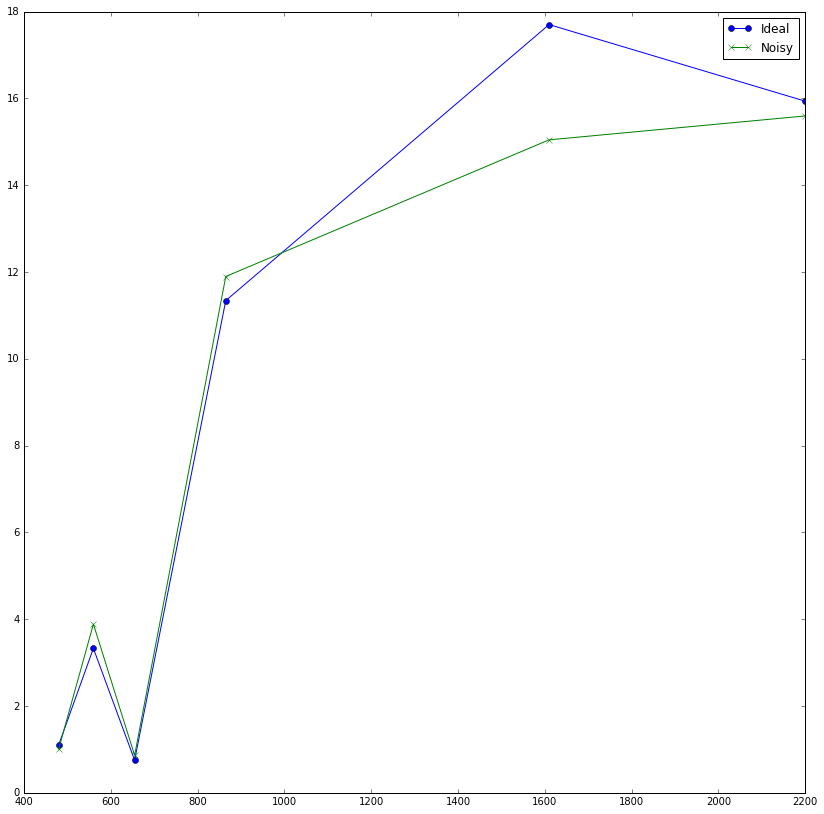

In [151]:
srf_l = np.loadtxt("./Landsat_RSR.csv", skiprows=1, delimiter=",")

#Bands of interest
# Band 2 Blue)	Band 3 (Green)	Band 4 (Red)	Band 5 (NiR)	Band 6 (SWIR 1)	Band 7 (SWIR 2)

srf_landsat = srf_l[:, [2, 3, 4, 5, 6,7]]
wv_landsat = np.array([480.0, 560.0, 655.0, 865.0, 1610.0,
                    2200.0])
# Apply the SRF to the data simulated above
rho_landsat_raw = (rho_syn[:, None]*srf_landsat)
rho_landsat = rho_landsat_raw.sum(axis=0)

# Add some grotty noise 10 % Normal distribution
rho_landsat_noise = rho_landsat + rho_landsat*0.1*np.random.randn(6)

# Plot stuff
plt.plot( wv_landsat, rho_landsat, 'o-', label="Ideal")
plt.plot( wv_landsat, rho_landsat_noise, '-x', label="Noisy")
plt.legend(loc="best")




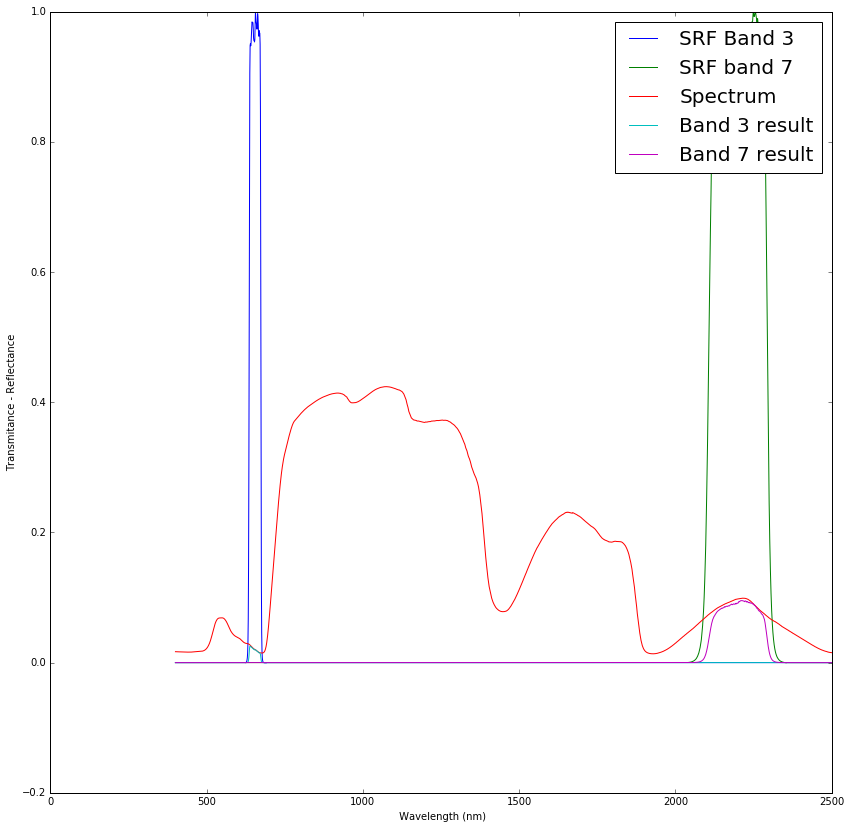

In [152]:
#Example, band 3
plt.plot(srf_l[:,0],srf_landsat[:,2],label="SRF Band 3")
plt.plot(srf_l[:,0],srf_landsat[:,5],label="SRF band 7")
plt.plot(srf_l[:,0],rho_syn,label="Spectrum")
plt.plot(srf_l[:,0],rho_landsat_raw[:,2],label="Band 3 result")
plt.plot(srf_l[:,0],rho_landsat_raw[:,5],label="Band 7 result")
plt.legend(loc='upper right',prop={'size': 20})
plt.xlabel(" Wavelength (nm)")
plt.ylabel("Transmitance - Reflectance")
plt.show()

This time, our cost function must include both likelihood and prior distributions. Thus, instead of (2) we get:

$$J(x)=\sum \frac{\left ( H(x)-y_{obs} \right )^{2}}{2\sigma^{2}} + (X-\mu)^{T}\Sigma^{-1}(X-\mu)$$

In order to find the maximum, we derive the cost function

$$J^{'}(x)=H^{'}(x)\frac{(H(x)-y_{obs})}{\sigma^{2}}+\Sigma^{-1}(X-\mu)$$

There is no analytic solution for the derivative of our observational operator, but the minimum of the cost function can be also retrieved using geometrical optimization as above (note that other approaches may be considered), so let's do it...

In [153]:
cov_=hes_I
mean_

array([ 39.2923759 ,   2.63051225])

In [154]:
def cost_func(x,lik=False):
    
    '''
    Return J at x
    '''
    cab=x[0]
    lai=x[1]
    n = 1.8
    
    car = 8.
    cbrown = 0.3
    cw = 0.013
    cm = 0.005
    lidfa = 45.
    # run the model forward. rsoil0 is the soil albedo array
    # assuming black soil
    rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    
    # Apply SRFs
    rho_pred = (rho[:, None]*srf_landsat).sum(axis=0)
    # Residual predicted - measured
    
    xx = rho_pred - rho_landsat_noise
    # Figure out noise. 
    sigma_obs = np.diag((rho_landsat_noise* 0.1)**2)
    Jlik=(0.5*np.dot(np.dot(xx.T,np.matrix(sigma_obs).I),xx))
    if lik:
        return Jlik
    X=np.asarray(x)
    Jpri=np.dot(np.dot((X-mean_).T,hes),(X-mean_))
    return Jlik+Jpri


x0=[0,0]
#Optimization
res = scipy.optimize.minimize(cost_func, x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
#Solution
print(res.x)

Optimization terminated successfully.
         Current function value: 4.507614
         Iterations: 109
         Function evaluations: 221
[ 36.6349496    2.59544715]


In [156]:
mean_update=res.x
cov_update=np.matrix(hessian(res.x,cost_func)).I

Optimization terminated successfully.
         Current function value: 2.345112
         Iterations: 123
         Function evaluations: 240


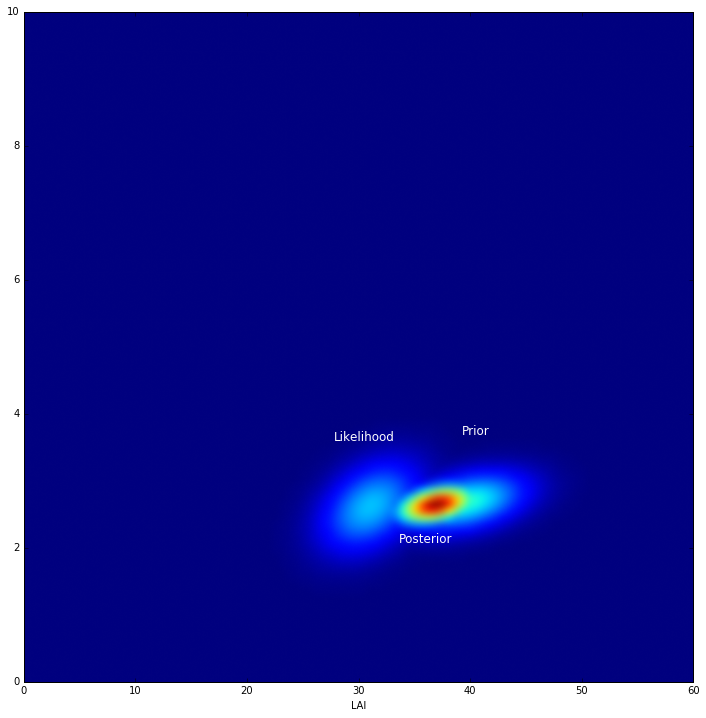

In [199]:
def prior(x):
    return multivariate_normal(mean=mean_, cov=hes_I).pdf(x)
like_mean=scipy.optimize.minimize(cost_func,x0,method='nelder-mead',options={'xtol': 1e-8, 'disp': True},\
                                  args=("lik=True")).x
def likelihood(x):
    return multivariate_normal(mean=like_mean,\
                                   cov=np.matrix(hessian(like_mean,cost_func,lik=True)).I).pdf(x)
def posterior(x):
    return multivariate_normal(mean=mean_update,cov=cov_update).pdf(x)
s=100
a=np.arange(0,60,60./s)
b=np.arange(0,10,10./s)
X,Y=np.meshgrid(a,b)
Z=np.zeros((s,s))
for i in range(s):
    for j in range(s):
        Z[i,j]=max(prior([X[i,j],Y[i,j]]),likelihood([X[i,j],Y[i,j]]),posterior([X[i,j],Y[i,j]]))
fig, ax = plt.subplots(figsize=(12,12))

ax.imshow(Z, interpolation='bicubic', extent=[0,60,0,10],origin="lower")
ax.set_aspect("auto")
ax.set_xlabel("CAB")
ax.set_xlabel("LAI")
ax.text(like_mean[0]-3,like_mean[1]*1.4,"Likelihood",fontsize=12, color='white')
ax.text(mean_[0],mean_[1]*1.4,"Prior",fontsize=12, color='white')
ax.text(mean_update[0]-3,mean_update[1]*0.8,"Posterior",fontsize=12, color='white')
plt.show()
